#  **ICT303 - Assignment 1**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>**

**Email: <enter here your email address>**






## **1. Description**

In this homework, you will build, train, test and compare the performance of multilayer perceptrons (MLP) and convolutional neural networks (CNNs) on a multi-class classification problem.

For this task, you will use the image dataset available [here](https://drive.google.com/file/d/1nWRm-Npq_QE0j_sHyVVxVEx2Rb0Lc1zU/view?usp=sharing). This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):




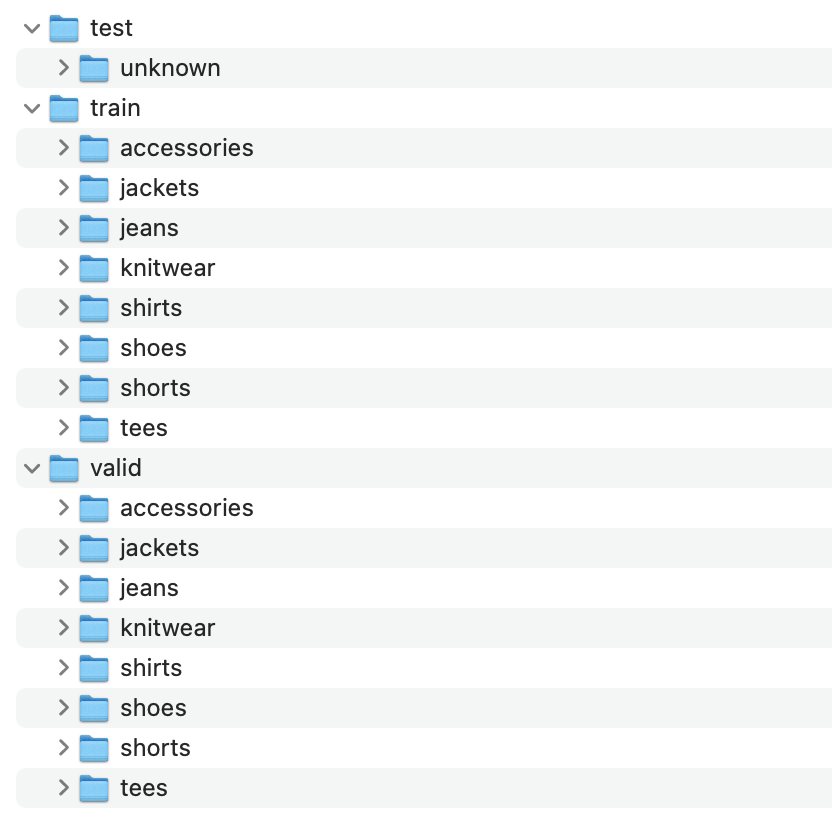


Your task is to:
1. Develop a multilayer perceptron model, train it and test it on the dataset. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
2. Implement VGG16, which a CNN architecture, train it and test it on the dataset. You must NOT use the pre-implemented VGG16 network in Pytorch. Instead, you have to implement all the layers and blocks yourself from scratch. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
3. Repeat step 2 above , but this time using the pretrained VGG16 network of PyTorch. **[20 Marks]**
4. For each of the tasks above, you need to finetune the hyper parameters to achieve the best performance possible.
5. Compare the performance of the three models.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

For Perth campus students, enrolled in internal model, you will be required to demonstrate your work in class. External students may be called to demonstrate the work to their tutor.

## **2. What do you need to submit**

You must submit:
- your source code, in the form of python libraries (i.e., .py files)
- A colab notebook that
 - Describes your solution and design choices. It is highly recommended to visually show the architecture of the networks you developed. You must include a discussion on how the hyper parameters affect performance and how did you select the ones you are currently using.
 - Demonstrates the training and testing of the machine learning models you developed.
 - Plots the training and validation curves for each model. You are requried to use TensorBoard for this task.
 - Analyzes the performance, in terms of Confusion Matrix and Mean Average Precision (MAE), of the methods, and how the hyper parameters affect this performance.
 - Allows the visualization of some classification results.

Important notes
- The performance of the machine learning models can be significantly affected by (1) the amount of data on which they are traiined, and (2) preprocessing, such as normalization, of the data (I will talk about this in class).
- Your program must be structured following what we have seen in the labs. In other words, you must use Object-oriented Programming and have a class for the data, a class for the model, a class for the trainer. You are allowed to reuse code you create in the labs. Also, you are allowed (in fact sometimes you should) reuse code across different models. For example, you only need one class to manage the data, whether you are using MLPs or CNNs (VGG16 in our case).
- We have zero tolerance for plagaiarsism and misconduct (e.g., asking AI to do the work for you).


## Load tensorboard

In [ ]:
%load_ext tensorboard
print("tensorboard extension loaded")

tensorboard extension loaded


## Import Dependencies and Data

In [ ]:
# required dependencies, uncomment line 8 below and run cell to install packages
'''
packages not used in labs and reason why im using it:
tqdm - monitor Epoch progress
scikit-learn - used for Model Evaluation (confusion matrix and mAP)
'''

#!pip install torch torchvision tqdm scikit-learn matplotlib tensorboard

In [ ]:
# From Python's Standard Library
import os
import shutil
import time
from collections import Counter # Used in get_class_weights in myDataLoader
# Others
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print("Dependencies Loaded!")

2025-06-18 21:04:35.595223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750251875.608747   27691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750251875.612930   27691 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750251875.623843   27691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750251875.623855   27691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750251875.623857   27691 computation_placer.cc:177] computation placer alr

Dependencies Loaded!


In [ ]:
# Uncomment if needed
'''
if os.path.exists("GoogleColab"):
    print("GoogleColab Folder exists, Deleting...")
    shutil.rmtree("GoogleColab")
    print("Done!")
'''
# Clone my GoogleColab repo containing the datasets
!git clone https://github.com/Aithusa712/GoogleColab.git

Cloning into 'GoogleColab'...
remote: Enumerating objects: 4104, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 4104 (delta 39), reused 32 (delta 2), pack-reused 3990 (from 2)
Receiving objects: 100% (4104/4104), 79.13 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
# For Linux
%cd GoogleColab/Assignment\ 1/

/home/aithusa/GoogleColab/Assignment 1


In [ ]:
# For Windows
%cd "GoogleColab/Assignment 1"

[Errno 2] No such file or directory: 'GoogleColab/Assignment 1'
/home/aithusa/GoogleColab/Assignment 1


In [ ]:
%ls

 data/  'ICT303 - Assignment 1.ipynb'


In [ ]:
torch.cuda.empty_cache()

## Models

### MLP class implementation based on MLP architecture
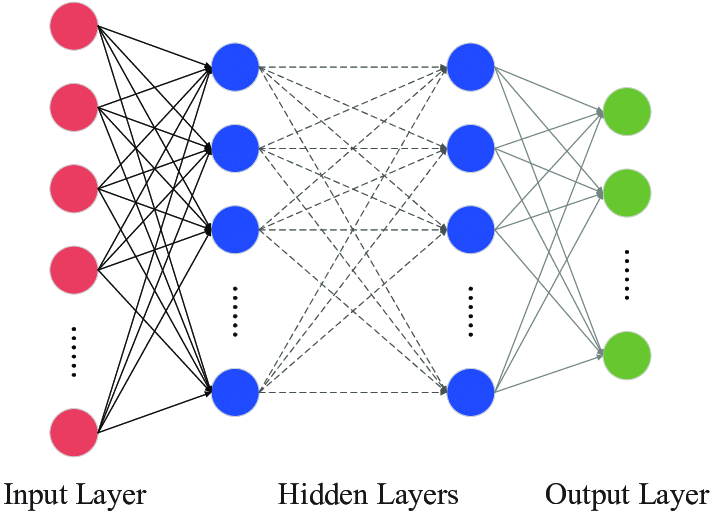

In [ ]:
## The MLP class
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=224 * 224 * 3, outputSize=8, lr=0.01, class_weights=None, dropout_rate = 0.3, optimizer_type = "adam"):
    super().__init__()

    self.lr = lr
    self.class_weights = class_weights
    self.optimizer_type = optimizer_type
    self.dropout_rate = dropout_rate

    self.layers = nn.Sequential(
        nn.Flatten(),
        # Input and First hidden Layer
        nn.Linear(inputSize, 512),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Second hidden Layer
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Output Layer
        nn.Linear(128, outputSize),
    )


  ## The forward step
  def forward(self, X):
    return self.layers(X)

  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss(weight=self.class_weights)
    return fn(y_hat, y)

  ## The optimization algorithm
  def configure_optimizers(self):
    if(self.optimizer_type=="adam"):
      return optim.Adam(self.parameters(), lr=self.lr)
    elif(self.optimizer_type=="sgd"):
      return optim.SGD(self.parameters(), lr=self.lr)
    else:
      return optim.Adam(self.parameters(), lr=self.lr)


### myVGG16 class implementation based on VGG16 Architecture
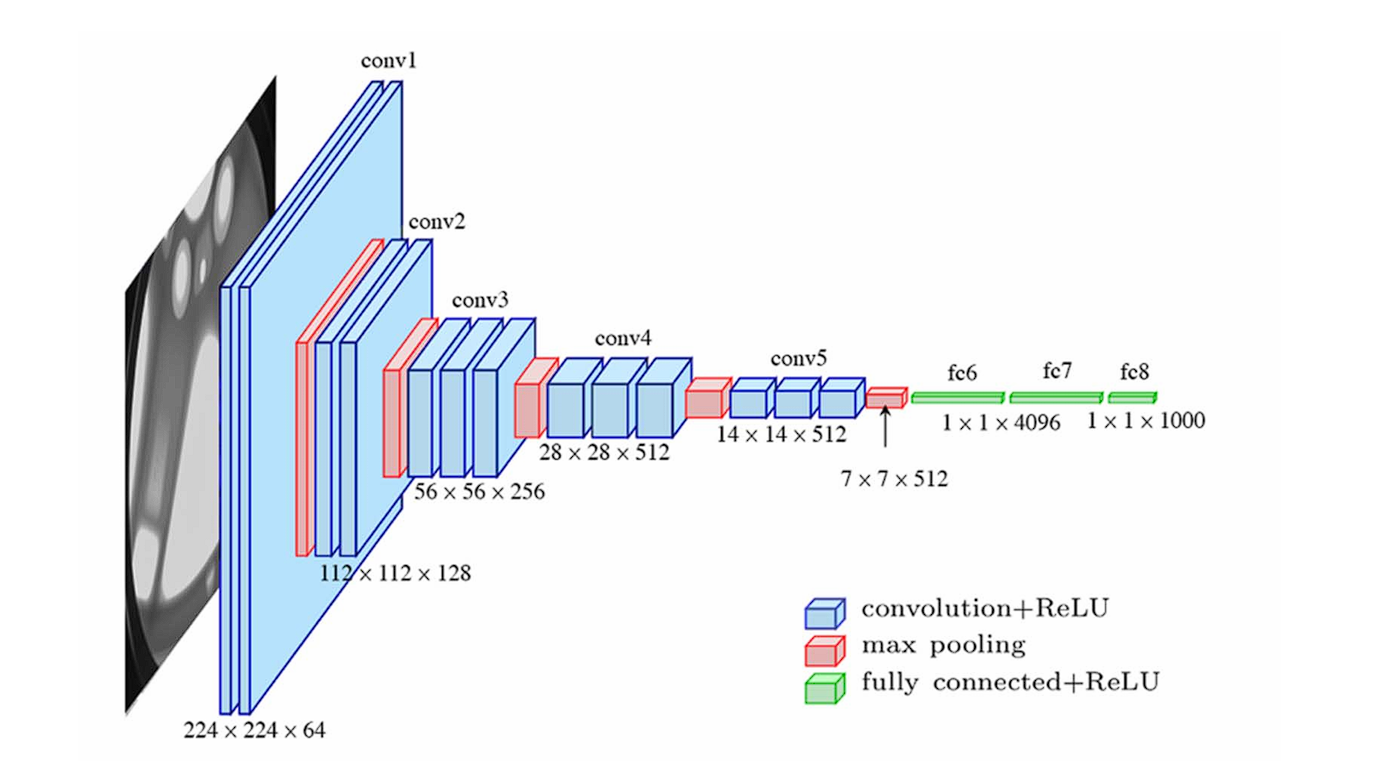

In [ ]:
class myVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-4, class_weights=None, dropout_rate=0.3, optimizer_type="adam"):
        super().__init__()

        self.lr = lr
        self.class_weights = class_weights
        self.optimizer_type = optimizer_type
        self.dropout_rate = dropout_rate

        # VGG-16 convolution blocks
        self.conv_layer = nn.Sequential(
            #conv1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),        # Convolution + ReLU
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),       # Convolution + ReLU
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv2
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),      # Convolution + ReLU
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv4
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            # conv5
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

        )

        # For 224x224 input

        self.fc_layer = nn.Sequential(
          # fc6
          nn.Linear(512 * 7 * 7, 1024),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc7
          nn.Linear(1024, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc8
          nn.Linear(512, outputSize)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

    def loss(self, y_hat, y):
       return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
      if(self.optimizer_type=="adam"):
        return optim.Adam(self.parameters(), lr=self.lr)
      elif(self.optimizer_type=="sgd"):
        return optim.SGD(self.parameters(), lr=self.lr)
      else:
        return optim.Adam(self.parameters(), lr=self.lr)


### Pytorch's Pretrained VGG16
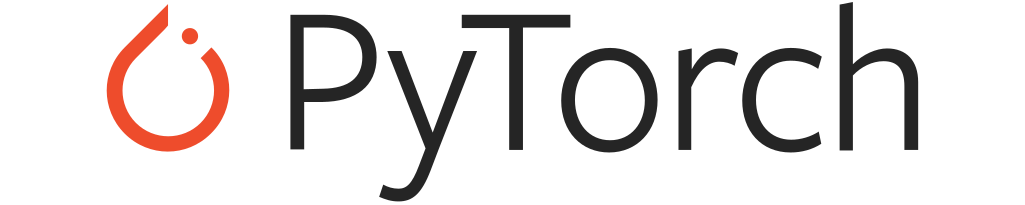

In [ ]:
class PretrainedVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-4, class_weights=None, dropout_rate=0.3, optimizer_type="adam", weight_decay=1e-4):
        super().__init__()

        self.lr = lr
        self.class_weights = class_weights
        self.optimizer_type = optimizer_type
        self.weight_decay=weight_decay
        self.dropout_rate = dropout_rate

        # Load pretrained VGG16 with batch normalization
        base_model = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT) #change to non BN variant

        # Freeze feature extractor if you want to fine-tune only classifier
        for param in base_model.features.parameters():
            param.requires_grad = False

        # Replace classifier with custom one
        base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, outputSize)
        )

        self.model = base_model

    def forward(self, x):
        return self.model(x)

    def loss(self, y_hat, y):
        return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
        if self.optimizer_type == "adam":
            return optim.Adam(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        elif self.optimizer_type == "sgd":
            return optim.SGD(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        else:
            return optim.Adam(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)


## Training Class

In [ ]:
class Trainer:

  def __init__(self, tb, n_epochs = 3):
    self.max_epochs = n_epochs
    self.writer = tb  # the tensorboard instance
    return

  def fit(self, model, data, validation_data):
    self.data = data
    self.validation_data = validation_data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    #self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.1)
    self.model     = model

    for epoch in range(self.max_epochs):
      print(f"\nEpoch {epoch + 1}/{self.max_epochs}")
      self.fit_epoch()
      self.validate_epoch()
      #self.scheduler.step()
      # Logging the average training loss so that it can be visualized in the tensorboard
      self.writer.add_scalar("Training Loss", self.avg_training_loss, epoch)
      self.writer.add_scalar("Validation Loss", self.avg_val_loss, epoch)

    print("Training process has finished")

  def fit_epoch(self):

    self.model.train()
    current_loss = 0.0
    self.avg_training_loss = 0.0

    # iterate over the DataLoader for training data
    for i, data in enumerate(tqdm(self.data, desc="Training")):
      # Get input
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device) # use GPU


      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t to the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statistics (average of the training loss over minibatches of 500 data items)
      current_loss += loss.item()

      # Adding training loss
      self.avg_training_loss += loss.item()

      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    # The average training loss
    self.avg_training_loss = self.avg_training_loss / i # to get the average
    print(f"Training Loss (avg): {self.avg_training_loss:.4f}")

  def validate_epoch(self):

    self.model.eval()
    total_loss = 0.0
    self.avg_val_loss = 0.0

    with torch.no_grad():
      # iterate over the DataLoader for training data
      for i, data in enumerate(self.validation_data):
        # Get input
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device) # use GPU

        # get output from the model, given the inputs
        outputs = self.model(inputs)

        # get loss for the predicted output
        loss = self.model.loss(outputs, target)

        total_loss += loss.item()

      # The average training loss
      self.avg_val_loss = total_loss / (i + 1) # to get the   average
      print(f"Validation Loss (avg): {self.avg_val_loss:.4f}")

## Data Loader Class

In [ ]:
class myDataLoader:
    def __init__(self, train_dir="data/train", val_dir="data/valid", image_size=(224, 224)):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))
        ])

    def get_data(self):
        # Load datasets with ImageFolder
        train_dataset = ImageFolder(root=self.train_dir, transform=self.transform)
        val_dataset = ImageFolder(root=self.val_dir, transform=self.transform)

        # Extract and save training data
        train_images, train_labels = zip(*[(img, label) for img, label in train_dataset])
        train_images = torch.stack(train_images)
        train_labels = torch.tensor(train_labels)
        torch.save((train_images, train_labels), "train_tensor.pt")
        print("Training data saved as train_tensor.pt")

        # Extract and save validation data
        val_images, val_labels = zip(*[(img, label) for img, label in val_dataset])
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        torch.save((val_images, val_labels), "val_tensor.pt")
        print("Validation data saved as valid_tensor.pt")

        # Save class names
        with open("classes.txt", "w") as f:
            for class_name in train_dataset.classes:
                f.write(f"{class_name}\n")

    def load_data(self):
        train_images, train_labels = torch.load("train_tensor.pt")
        val_images, val_labels = torch.load("val_tensor.pt")
        with open("classes.txt", "r") as f:
            class_names = [line.strip() for line in f]
        return train_images, train_labels, val_images, val_labels, class_names

    def get_class_weights(self, labels, num_classes, device):
        label_counts = Counter(labels.tolist())
        class_weights = [(1 / label_counts[i]) ** 0.5 for i in range(num_classes)]
        return torch.tensor(class_weights, dtype=torch.float).to(device)

## Main Program

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Prepare / Load Data
print("Preparing and Loading Data....")
data_loader = myDataLoader()
data_loader.get_data()
train_images, train_labels, val_images, val_labels, class_names = data_loader.load_data()
print("Finished loading!")



# Compute class weights
num_classes = len(class_names)
class_weights = data_loader.get_class_weights(train_labels, num_classes, device)



Using device: cuda
Preparing and Loading Data....
Training data saved as train_tensor.pt
Validation data saved as valid_tensor.pt
Finished loading!


## Tune Hyperparameters

In [ ]:
batch_size = 32
optimizer_type = "adam"
#64 - OOM on my local GPU (12Gb)
#32 - stable - nvidia-smi output: /.venvs/mlenv/bin/python3.12   9116MiB
# Adam optimzer - It performed better then SGD when I did some tests

### MLP

In [ ]:
mlp_n_epochs = 17
mlp_lr = 1e-5
#5e-3 #5e-4 #5e-5
#13 Epochs - val loss still decreasing
#20 Epochs - after the 17th epoch gains are minimal b

### myVGG16

In [ ]:
myVGG16_n_epochs = 7
myVGG16_lr = 1e-5
# 1e-5 - slow but stable
# 4096 fc layer size - unstable
# 15 Epochs - Validation loss fluctuates after epoch 10
# 7 Epochs - best model

### pretrained_VGG16

In [ ]:
pretrained_VGG16_n_epochs = 7
pretrained_VGG16_lr = 1e-5
# 1e-5 - stable
# 15 Epochs - after epoch 10 values didnt improve much
# 10 Epochs - best model
# 7 Epochs - is used to easily compare myVGG16 to this model

## Create Datasets and DataLoaders

In [ ]:
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=12, pin_memory=True)

## Training

### Train MLP Model

In [ ]:
print(f"Learning Rate: {mlp_lr}")
print(f"Max Epoch: {mlp_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/mlp'):
  shutil.rmtree('runs/mlp')
mlp_writer = SummaryWriter('runs/mlp')
# Initialize Model
mlp_model = MLP(outputSize=num_classes, lr=mlp_lr, class_weights=class_weights,optimizer_type=optimizer_type).to(device)
# Train MLP model
mlp_trainer = Trainer(mlp_writer, mlp_n_epochs)
mlp_trainer.fit(mlp_model, train_loader, val_loader)

Learning Rate: 0.0005
Max Epoch: 20
Batch Size: 32

Epoch 1/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 30.63it/s]

Training Loss (avg): 2.5793


Validation Loss (avg): 1.0909

Epoch 2/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.51it/s]

Training Loss (avg): 1.1475


Validation Loss (avg): 0.9999

Epoch 3/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.44it/s]

Training Loss (avg): 0.9845


Validation Loss (avg): 0.8326

Epoch 4/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.41it/s]

Training Loss (avg): 0.8550


Validation Loss (avg): 0.7751

Epoch 5/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.40it/s]

Training Loss (avg): 0.8031


Validation Loss (avg): 0.7620

Epoch 6/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.08it/s]

Training Loss (avg): 0.7714


Validation Loss (avg): 0.7794

Epoch 7/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.21it/s]

Training Loss (avg): 0.7643


Validation Loss (avg): 0.7367

Epoch 8/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.09it/s]

Training Loss (avg): 0.7240


Validation Loss (avg): 0.7638

Epoch 9/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.40it/s]

Training Loss (avg): 0.6942


Validation Loss (avg): 0.7230

Epoch 10/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.04it/s]

Training Loss (avg): 0.6688


Validation Loss (avg): 0.7171

Epoch 11/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 35.90it/s]

Training Loss (avg): 0.6692


Validation Loss (avg): 0.7838

Epoch 12/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.00it/s]

Training Loss (avg): 0.6647


Validation Loss (avg): 0.7198

Epoch 13/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.56it/s]

Training Loss (avg): 0.5951


Validation Loss (avg): 0.7295

Epoch 14/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.42it/s]

Training Loss (avg): 0.6161


Validation Loss (avg): 0.6876

Epoch 15/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.37it/s]

Training Loss (avg): 0.6302


Validation Loss (avg): 0.6971

Epoch 16/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 36.52it/s]

Training Loss (avg): 0.6022


Validation Loss (avg): 0.6417

Epoch 17/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.21it/s]

Training Loss (avg): 0.5596


Validation Loss (avg): 0.6447

Epoch 18/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 36.08it/s]

Training Loss (avg): 0.5859


Validation Loss (avg): 0.6626

Epoch 19/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 35.75it/s]

Training Loss (avg): 0.5537


Validation Loss (avg): 0.6738

Epoch 20/20


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 35.73it/s]

Training Loss (avg): 0.5716


Validation Loss (avg): 0.6712
Training process has finished


### Train myVGG16 Model

In [ ]:
print(f"Learning Rate: {myVGG16_lr}")
print(f"Max Epoch: {myVGG16_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/my_vgg16'):
  shutil.rmtree('runs/my_vgg16')
vgg16_writer = SummaryWriter('runs/my_vgg16')
# Initialize Model
myVGG16_model = myVGG16(outputSize=num_classes, lr=myVGG16_lr, class_weights=class_weights, optimizer_type=optimizer_type).to(device)
# Train myVGG16 Model
vgg16_trainer = Trainer(vgg16_writer, myVGG16_n_epochs)
vgg16_trainer.fit(myVGG16_model, train_loader, val_loader)
vgg16_writer.close()

Learning Rate: 1e-05
Max Epoch: 15
Batch Size: 32

Epoch 1/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.34it/s]

Training Loss (avg): 1.1260


Validation Loss (avg): 0.6176

Epoch 2/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]


Training Loss (avg): 0.5205
Validation Loss (avg): 0.3472

Epoch 3/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.37it/s]

Training Loss (avg): 0.3370


Validation Loss (avg): 0.3125

Epoch 4/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.36it/s]

Training Loss (avg): 0.2599


Validation Loss (avg): 0.3012

Epoch 5/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.34it/s]


Training Loss (avg): 0.1866
Validation Loss (avg): 0.2330

Epoch 6/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]


Training Loss (avg): 0.1197
Validation Loss (avg): 0.2292

Epoch 7/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]

Training Loss (avg): 0.0814


Validation Loss (avg): 0.1982

Epoch 8/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.37it/s]

Training Loss (avg): 0.0563


Validation Loss (avg): 0.1980

Epoch 9/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]

Training Loss (avg): 0.0354


Validation Loss (avg): 0.2017

Epoch 10/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]


Training Loss (avg): 0.0223
Validation Loss (avg): 0.1850

Epoch 11/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.37it/s]

Training Loss (avg): 0.0121


Validation Loss (avg): 0.2018

Epoch 12/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.37it/s]

Training Loss (avg): 0.0084


Validation Loss (avg): 0.1905

Epoch 13/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.36it/s]

Training Loss (avg): 0.0089


Validation Loss (avg): 0.2060

Epoch 14/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:46<00:00,  2.36it/s]

Training Loss (avg): 0.0280


Validation Loss (avg): 0.1881

Epoch 15/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:45<00:00,  2.38it/s]

Training Loss (avg): 0.0109


Validation Loss (avg): 0.1776
Training process has finished


### Train PretrainedVGG16 Model

In [ ]:
print(f"Learning Rate: {pretrained_VGG16_lr}")
print(f"Max Epoch: {pretrained_VGG16_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/pretrained_VGG16'):
  shutil.rmtree('runs/pretrained_VGG16')
pretrainedVGG16_writer = SummaryWriter('runs/pretrained_vgg16')
# Initialize Model
pretrainedVGG16_model = PretrainedVGG16(outputSize=num_classes, lr=pretrained_VGG16_lr, class_weights=class_weights, optimizer_type=optimizer_type).to(device)
# Train myVGG16 Model
pretrainedVGG16_trainer = Trainer(pretrainedVGG16_writer, pretrained_VGG16_n_epochs)
pretrainedVGG16_trainer.fit(pretrainedVGG16_model, train_loader, val_loader)
pretrainedVGG16_writer.close()

Learning Rate: 1e-05
Max Epoch: 15
Batch Size: 32

Epoch 1/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.45it/s]

Training Loss (avg): 1.0128


Validation Loss (avg): 0.3324

Epoch 2/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.47it/s]

Training Loss (avg): 0.2548


Validation Loss (avg): 0.1595

Epoch 3/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.49it/s]

Training Loss (avg): 0.1223


Validation Loss (avg): 0.1238

Epoch 4/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.47it/s]

Training Loss (avg): 0.0757


Validation Loss (avg): 0.1129

Epoch 5/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.48it/s]

Training Loss (avg): 0.0469


Validation Loss (avg): 0.1092

Epoch 6/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.64it/s]

Training Loss (avg): 0.0277


Validation Loss (avg): 0.0998

Epoch 7/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.47it/s]

Training Loss (avg): 0.0196


Validation Loss (avg): 0.0924

Epoch 8/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:18<00:00,  5.87it/s]

Training Loss (avg): 0.0152


Validation Loss (avg): 0.0951

Epoch 9/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.63it/s]

Training Loss (avg): 0.0113


Validation Loss (avg): 0.0945

Epoch 10/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.70it/s]

Training Loss (avg): 0.0069


Validation Loss (avg): 0.0904

Epoch 11/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.48it/s]

Training Loss (avg): 0.0057


Validation Loss (avg): 0.0937

Epoch 12/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.48it/s]

Training Loss (avg): 0.0048


Validation Loss (avg): 0.0881

Epoch 13/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.70it/s]

Training Loss (avg): 0.0036


Validation Loss (avg): 0.0894

Epoch 14/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.47it/s]

Training Loss (avg): 0.0032


Validation Loss (avg): 0.0911

Epoch 15/15


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.49it/s]

Training Loss (avg): 0.0027


Validation Loss (avg): 0.0955
Training process has finished


## Testing and Evaluation


## Model Evaluator class - contains all evaluating functions

In [ ]:
class ModelEvaluator:

    def __init__(self, model, model_name, device, dataloader, class_names, class_file=None):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.dataloader = dataloader
        self.class_names = class_names
        self.class_file = class_file
        self.y_true = None
        self.y_pred = None

    # Model Accuracy
    def test_model_on_device(self):
        self.model.eval()
        correct = 0
        total = 0
        start = time.time()
        with torch.no_grad():
            for images, labels in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        end = time.time()
        print(f"Accuracy: {100 * correct / total:.2f}% - Inference Time: {end - start:.2f}s")

    # Model Prediction Visualization
    def model_predictions_visualization(self, test_dir="data/test", num_samples=8):
        if self.class_file is not None:
            with open(self.class_file, "r") as f:
                self.class_names = [line.strip() for line in f]

        test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        test_dataset = ImageFolder(root=test_dir, transform=test_transform)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        self.model.eval()

        test_images = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                test_images.extend(inputs)
                if len(test_images) >= num_samples:
                    break

        inputs = torch.stack(test_images[:num_samples]).to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs)
            _, predicted = torch.max(outputs, 1)

        fig, axs = plt.subplots(1, num_samples, figsize=(2 * num_samples, 3))
        fig.suptitle(f"{self.model_name} Predictions", fontsize=14)

        for i in range(num_samples):
            img = inputs[i].cpu() * 0.5 + 0.5  # Unnormalize
            img_np = img.permute(1, 2, 0).numpy()

            pred_idx = predicted[i].item()
            label = self.class_names[pred_idx] if pred_idx < len(self.class_names) else "Invalid"

            ax = axs[i] if num_samples > 1 else axs
            ax.imshow(img_np)
            ax.axis('off')
            ax.set_title(f"{label}", fontsize=9, pad=6)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

    # Get Label and prediction values
    def evaluate_model(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data, labels in self.dataloader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        self.y_true = np.concatenate(all_labels)
        self.y_pred = np.concatenate(all_preds)

    # Plot a Confusion Matrix
    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.y_true, self.y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"Confusion Matrix: {self.model_name}")
        plt.show()

    # Print Classification Report
    def print_classification_report(self):
        report = classification_report(self.y_true, self.y_pred, target_names=self.class_names)
        print(f"\nClassification Report for {self.model_name}:\n{report}")


### MLP Evaluation


MLP:
Accuracy: 82.46% - Inference Time: 0.60s


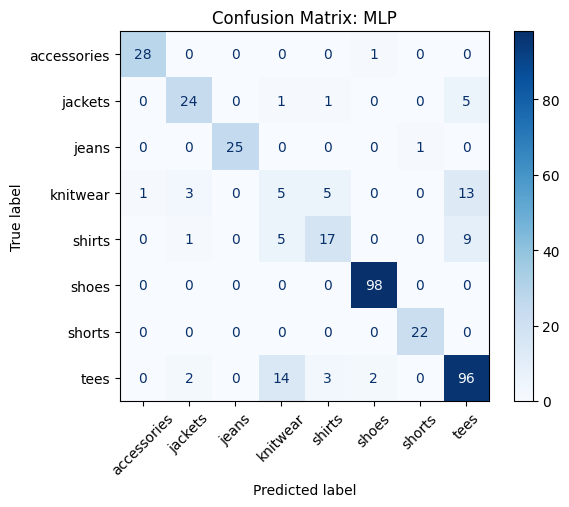


Classification Report for MLP:
              precision    recall  f1-score   support

 accessories       0.97      0.97      0.97        29
     jackets       0.80      0.77      0.79        31
       jeans       1.00      0.96      0.98        26
    knitwear       0.20      0.19      0.19        27
      shirts       0.65      0.53      0.59        32
       shoes       0.97      1.00      0.98        98
      shorts       0.96      1.00      0.98        22
        tees       0.78      0.82      0.80       117

    accuracy                           0.82       382
   macro avg       0.79      0.78      0.78       382
weighted avg       0.82      0.82      0.82       382



In [ ]:
# MLP implementation using ModelEvaluator class
print("MLP:")

# Create evaluator instance
evaluator_mlp = ModelEvaluator(
    model=mlp_model,
    model_name="MLP",
    device=device,
    dataloader=val_loader,
    class_names=class_names
)

# Run test on device (accuracy + inference time)
evaluator_mlp.test_model_on_device()

# Run evaluation to get predictions
evaluator_mlp.evaluate_model()

# Plot confusion matrix
evaluator_mlp.plot_confusion_matrix()

# Print classification report
evaluator_mlp.print_classification_report()


### myVGG16 Evaluation

my VGG16:
Accuracy: 93.72% - Inference Time: 2.11s


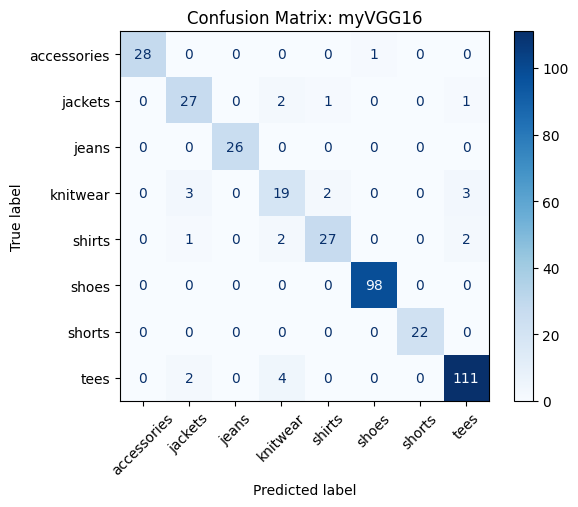


Classification Report for myVGG16:
              precision    recall  f1-score   support

 accessories       1.00      0.97      0.98        29
     jackets       0.82      0.87      0.84        31
       jeans       1.00      1.00      1.00        26
    knitwear       0.70      0.70      0.70        27
      shirts       0.90      0.84      0.87        32
       shoes       0.99      1.00      0.99        98
      shorts       1.00      1.00      1.00        22
        tees       0.95      0.95      0.95       117

    accuracy                           0.94       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.94      0.94      0.94       382



In [ ]:
# myVGG16 implementation using ModelEvaluator class
print("my VGG16:")

# Create evaluator instance
evaluator_myvgg = ModelEvaluator(
    model=myVGG16_model,
    model_name="myVGG16",
    device=device,
    dataloader=val_loader,
    class_names=class_names
)

# Run test on device (accuracy + inference time)
evaluator_myvgg.test_model_on_device()

# Run evaluation to get predictions
evaluator_myvgg.evaluate_model()

# Plot confusion matrix
evaluator_myvgg.plot_confusion_matrix()

# Print classification report
evaluator_myvgg.print_classification_report()


Pretrained VGG16:
Accuracy: 96.34% - Inference Time: 1.96s


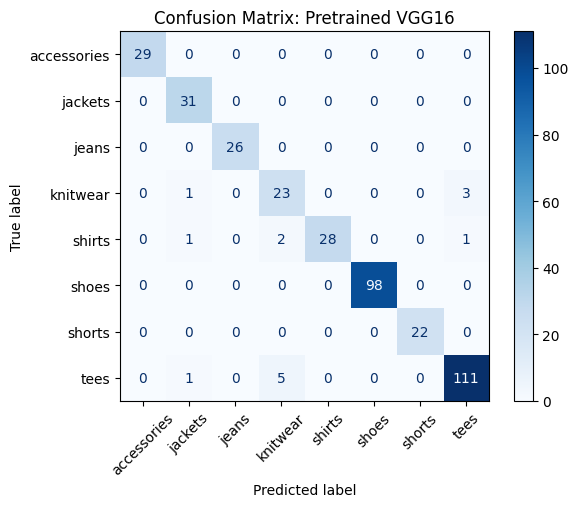


Classification Report for Pretrained VGG16:
              precision    recall  f1-score   support

 accessories       1.00      1.00      1.00        29
     jackets       0.91      1.00      0.95        31
       jeans       1.00      1.00      1.00        26
    knitwear       0.77      0.85      0.81        27
      shirts       1.00      0.88      0.93        32
       shoes       1.00      1.00      1.00        98
      shorts       1.00      1.00      1.00        22
        tees       0.97      0.95      0.96       117

    accuracy                           0.96       382
   macro avg       0.96      0.96      0.96       382
weighted avg       0.97      0.96      0.96       382



In [ ]:
# Pretrained VGG16 implementation using ModelEvaluator class
print("Pretrained VGG16:")

# Create evaluator instance
evaluator_pretrained = ModelEvaluator(
    model=pretrainedVGG16_model,
    model_name="Pretrained VGG16",
    device=device,
    dataloader=val_loader,
    class_names=class_names
)

# Run test on device (accuracy + inference time)
evaluator_pretrained.test_model_on_device()

# Run evaluation to get predictions
evaluator_pretrained.evaluate_model()

# Plot confusion matrix
evaluator_pretrained.plot_confusion_matrix()

# Print classification report
evaluator_pretrained.print_classification_report()


## Classification results Visualization

### MLP test Visualization

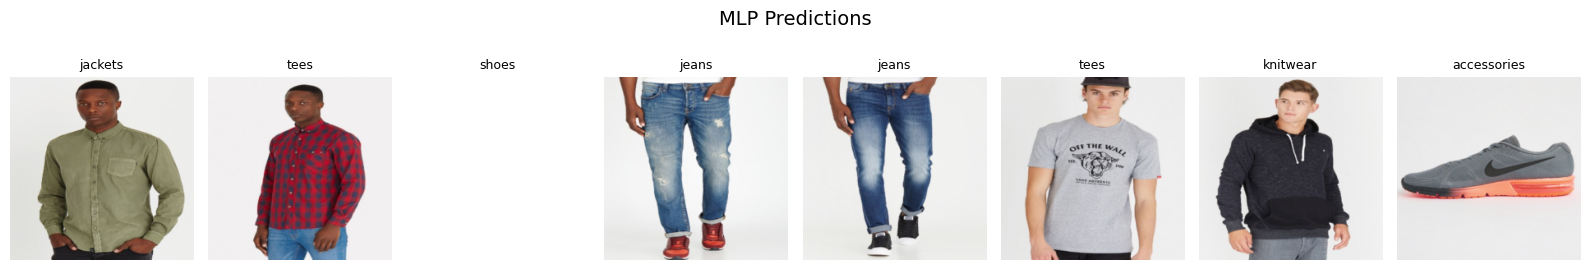

In [ ]:
evaluator_mlp.model_predictions_visualization()

### myVGG16 test Visualization

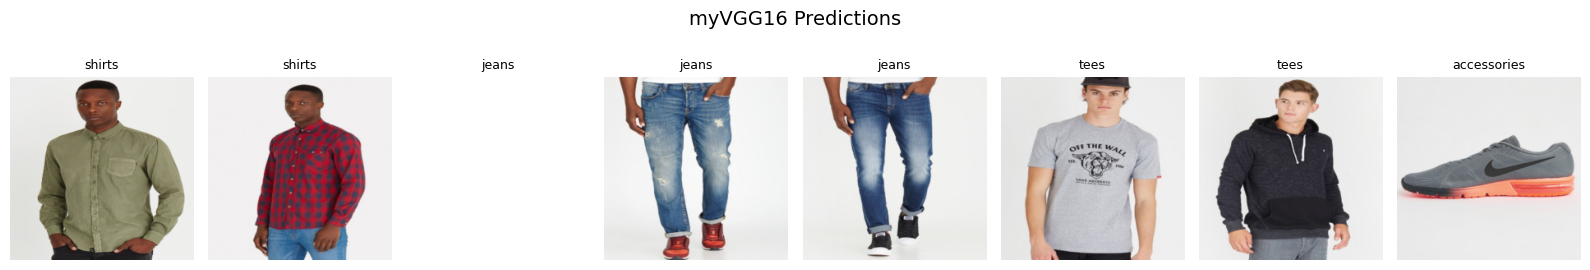

In [ ]:
evaluator_myvgg.model_predictions_visualization()

### Pretrained VGG16 test Visualization

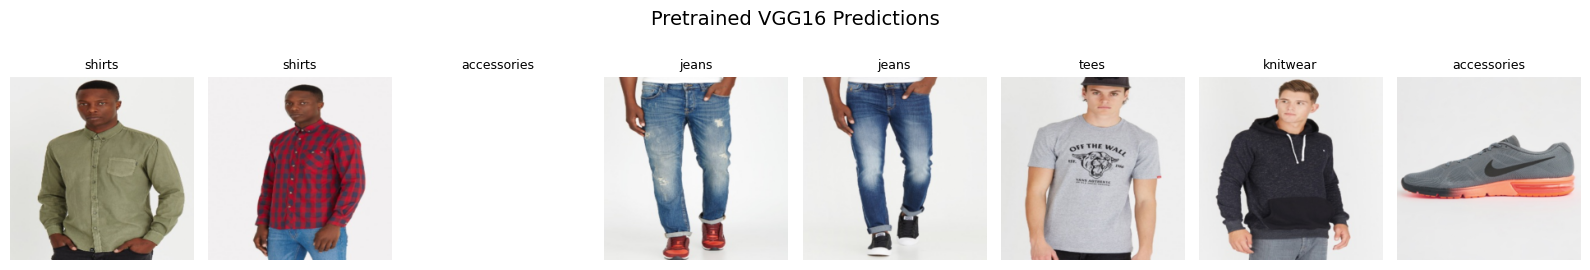

In [ ]:
evaluator_pretrained.model_predictions_visualization()

Tensorboard Output:

In [ ]:
tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 21259), started 0:57:26 ago. (Use '!kill 21259' to kill it.)

Save Models

In [ ]:
#torch.save(mlp_model.state_dict(), "mlp_model.pth")  # For MLP
#torch.save(myVGG16_model.state_dict(), "vgg16_model.pth")  # For VGG16
#torch.save(pretrainedVGG16_model.state_dict(), "pytorch_vgg16_model.pth")  # For  pretrained VGG16